In [21]:
# For PyTorch:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())





2.5.1
CUDA available: True


In [22]:
import transformers

print("Transformers version:", transformers.__version__)


Transformers version: 4.45.2


In [23]:

import datasets

print("Datasets version:", datasets.__version__)

Datasets version: 2.19.1


In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments


In [25]:
import evaluate
import numpy as npcond
from datasets import load_metric, load_dataset
import random

In [26]:
# Defining a constant SEED for reproducibility in random operations
SEED = 42

# Setting the seed for the random library to ensure consistent results
random.seed(SEED)

In [27]:
# 'star' is a column in our dataset and we want to convert it to a ClassLabel column
# so we can stratify our samples.

# Importing the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Loading the 'app_reviews' dataset's training split into the 'dataset' variable
dataset = load_dataset('app_reviews', split='train')

# Converting the 'star' column in our dataset to a ClassLabel type
# This allows for categorical representation and easier handling of classes
dataset = dataset.class_encode_column('star')

# Displaying the dataset to see the changes
dataset

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [28]:
# Splitting the dataset into a training set and a test set.
# We reserve 20% of the data for testing and use stratification on the 'star' column
# to ensure both sets have an equal distribution of each star category.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

# Now, we further split our training dataset to reserve 25% of it for validation.
# Again, we stratify by the 'star' column to keep the distribution consistent.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

# Assigning the split datasets to their respective keys:
# - The remaining 75% of our initial training data becomes the new training dataset.
dataset['train'] = df['train']

# - The 25% split from our initial training data becomes the validation dataset.
dataset['val'] = df['test']

# Displaying the dataset to see the distribution across train, test, and validation sets.
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [29]:
MODEL = 'distilbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(MODEL)

loading configuration file config.json from cache at C:\Users\ranga\.cache\huggingface\hub\models--distilbert-base-cased\snapshots\6ea81172465e8b0ad3fddeed32b986cdcdcffcf0\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.45.2",
  "vocab_size": 28996
}

loading file vocab.txt from cache at C:\Users\ranga\.cache\huggingface\hub\models--distilbert-base-cased\snapshots\6ea81172465e8b0ad3fddeed32b986cdcdcffcf0\vocab.txt
loading file tokenizer.json from cache at C:\Users\ranga\.cache\huggingfac

In [30]:
# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):  # each example is an element from the Dataset
    return tokenizer(examples["review"], truncation=True)

In [31]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the 
#  length of the longest element in the batch, making them all the same length. 
#  It's possible to pad your text in the tokenizer function with padding=True, dynamic padding is more efficient.

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [32]:
sequence_clf_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5,
)

loading configuration file config.json from cache at C:\Users\ranga\.cache\huggingface\hub\models--distilbert-base-cased\snapshots\6ea81172465e8b0ad3fddeed32b986cdcdcffcf0\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.45.2",
  "vocab_size": 28996
}

loading we

In [33]:
sequence_clf_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [34]:
dataset = dataset.map(preprocess_function, batched=True)

In [35]:
dataset = dataset.rename_column("star", "label")
dataset = dataset.remove_columns(['package_name', 'review', 'date'])
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

<Axes: >

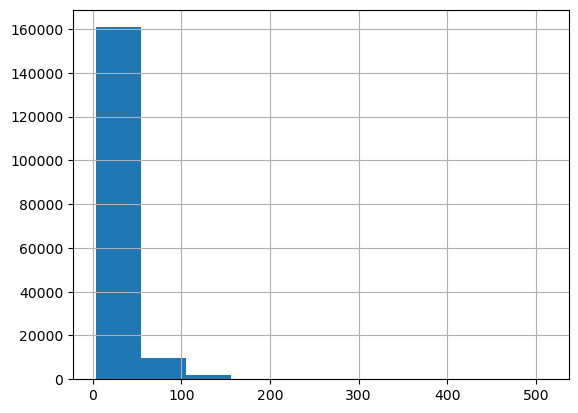

In [36]:
import pandas as pd

input_ids = dataset['train']['input_ids']
pd.Series(input_ids).apply(len).hist()

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 57613
    })
})

In [38]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}


In [39]:
epochs = 2

training_args = TrainingArguments(
    output_dir="./bert_clf_results",
    num_train_epochs=epochs,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
    
    # Some deep learning parameters
    warmup_ratio=0.1,
    weight_decay=0.05,
    
    logging_steps=1,
    log_level='info',
    eval_strategy='epoch',  # Updated parameter
    eval_steps=50,
    save_strategy='epoch'
)


# Define the trainer:

trainer = Trainer(
    model=sequence_clf_model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    compute_metrics=compute_metrics,  # optional
    data_collator=data_collator  # technically optional
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [43]:
import numpy as np
trainer.evaluate()


***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32


{'eval_loss': 1.6418410539627075,
 'eval_model_preparation_time': 0.001,
 'eval_accuracy': 0.08052002152292018,
 'eval_runtime': 61.4392,
 'eval_samples_per_second': 937.724,
 'eval_steps_per_second': 29.314}

In [44]:
trainer.train()

***** Running training *****
  Num examples = 172,839
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 10,802
  Number of trainable parameters = 65,785,349


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
0,1.033400,0.835022,0.001000,0.712044
1,0.636800,0.820615,0.001000,0.716817



***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
Saving model checkpoint to ./bert_clf_results\checkpoint-5401
Configuration saved in ./bert_clf_results\checkpoint-5401\config.json
Model weights saved in ./bert_clf_results\checkpoint-5401\model.safetensors
Saving model checkpoint to ./bert_clf_results\checkpoint-10802
Configuration saved in ./bert_clf_results\checkpoint-10802\config.json
Model weights saved in ./bert_clf_results\checkpoint-10802\model.safetensors

***** Running Evaluation *****
  Num examples = 57613
  Batch size = 32
Saving model checkpoint to ./bert_clf_results\checkpoint-10802
Configuration saved in ./bert_clf_results\checkpoint-10802\config.json
Model weights saved in ./bert_clf_results\checkpoint-10802\model.safetensors


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_clf_results\checkpoint-10802 (score: 0.8206145167350769).


TrainOutput(global_step=10802, training_loss=0.828483936148393, metrics={'train_runtime': 1323.3475, 'train_samples_per_second': 261.215, 'train_steps_per_second': 8.163, 'total_flos': 7021672727177670.0, 'train_loss': 0.828483936148393, 'epoch': 1.999814866240859})

In [ ]:
# See colab link for comparison on there!
# compare to fine tuned gpt 3.5
    # accuracy
    # cost to train/host (on HF or make your own API)
    # latency/throughput
    